In [78]:
import pandas as pd
from pathlib import Path
import os
import glob


In [79]:
def create_df_for_program(program_directory:Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    run_stats_directory=Path(program_directory, "run_stats")
    AvgCPU_data=[]
    MemPerc_data=[]
    for stats_file in list(run_stats_directory.glob('*.csv')):
        stats_file_df=pd.read_csv(stats_file, usecols=['AvgCPU', 'MemPerc'])
        AvgCPU_data.append(stats_file_df['AvgCPU'].tolist())
        MemPerc_data.append(stats_file_df['MemPerc'].tolist())
    AvgCPU_df=pd.DataFrame(AvgCPU_data).transpose()
    MemPerc_df=pd.DataFrame(MemPerc_data).transpose()
    return (AvgCPU_df, MemPerc_df)

In [80]:
def process_CPU_utilisation(df:pd.DataFrame, program_title:str):
    df['time_elapsed_mean']=df.mean(axis=1) #mean value for per second reading over replicant runs
    df.loc['run_mean']=df.mean() #mean value for run
    df.iloc[0:-1].plot(legend=True, title=program_title+" CPU utilisation")

In [81]:
def process_program_stats(program_directory:Path):
    AvgCPU_df, MemPerc_df = create_df_for_program(program_directory)
    process_CPU_utilisation(AvgCPU_df, program_directory.name)
    #return AvgCPU_df

In [82]:
path_to_data=Path(Path().resolve().parent, "data", "results")
program_directories = [x for x in path_to_data.iterdir() if x.is_dir()]

None
None
None


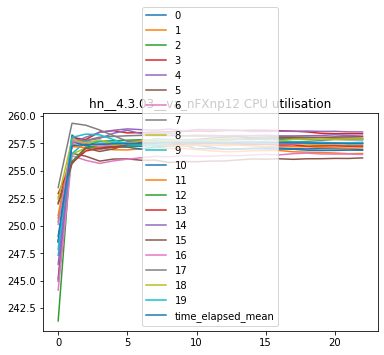

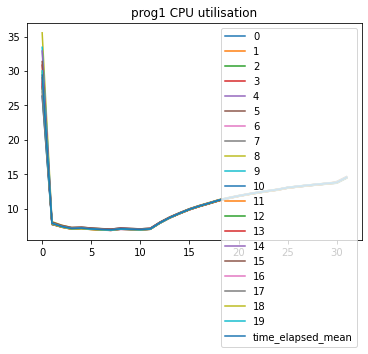

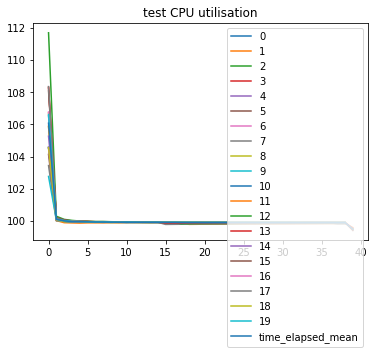

In [83]:
for program_directory in program_directories:
    print(process_program_stats(program_directory))
